# 基于movehub的数据，分析城市的宜居度

根据源数据（11个指标的数据），建立城市画像，在做线性回归模型前，验证指标与城市宜居指数的相关性。

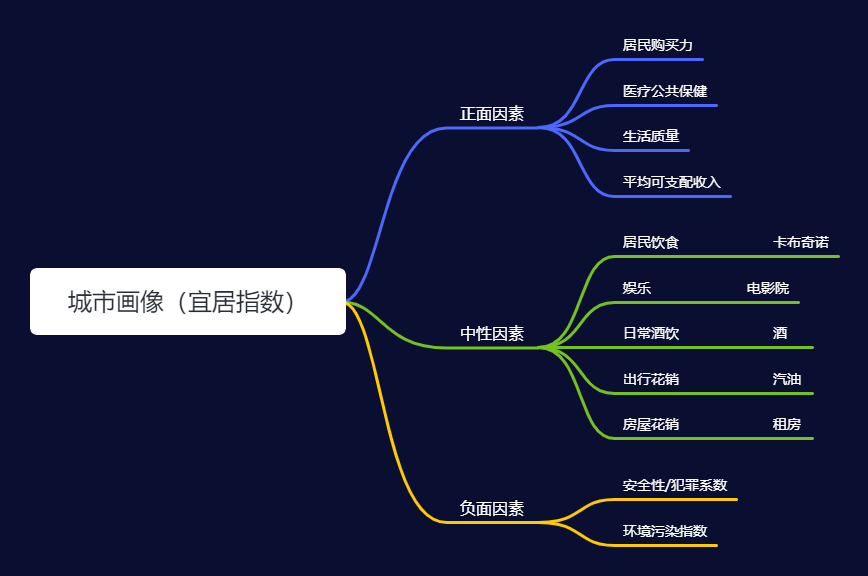

数据预处理

导入库

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scipy
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, accuracy_score 
from sklearn import linear_model
import warnings 
import math

导入数据集

In [9]:
city_data = pd.read_csv('datasets/cities.csv') 
quality_data= pd.read_csv('datasets/movehubqualityoflife.csv')
cost_data= pd.read_csv('datasets/movehubcostofliving.csv')

查看数据特征

In [4]:
city_data.head()

,City,Country
0,Oakland,United States
1,Oakville,Canada
2,Oaxaca de Juárez,Mexico
3,Oberhausen,Germany
4,Obihiro,Japan


In [5]:
city_data.shape

(3543, 2)

In [6]:
quality_data.head()

,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating
0,Caracas,65.18,11.25,44.44,83.45,8.61,85.70
1,Johannesburg,84.08,53.99,59.98,47.39,51.26,83.93
2,Fortaleza,80.17,52.28,45.46,66.32,36.68,78.65
3,Saint Louis,85.25,80.40,77.29,31.33,87.51,78.13
4,Mexico City,75.07,24.28,61.76,18.95,27.91,77.86


In [7]:
quality_data.shape

(216, 7)

In [10]:
cost_data.head()

,City,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income
0,Lausanne,3.15,12.59,8.40,1.32,1714.00,4266.11
1,Zurich,3.28,12.59,8.40,1.31,2378.61,4197.55
2,Geneva,2.80,12.94,10.49,1.28,2607.95,3917.72
3,Basel,3.50,11.89,7.35,1.25,1649.29,3847.76
4,Perth,2.87,11.43,10.08,0.97,2083.14,3358.55


In [11]:
cost_data.shape

(216, 7)

数据清洗

In [13]:
city_data.isna().sum()

City       0
Country    3
dtype: int64

In [14]:
city_data[city_data['Country'].isnull()]

,City,Country
654,Sevastopol,NaN
724,Simferopol,NaN
1529,Priština,NaN


In [15]:
#数据填充，正确的国家
city_data.iloc[654, 1]= 'Ukraine'
city_data.iloc[724, 1]= 'Russia'
city_data.iloc[1529, 1]= 'Kosovo'

将 DataFrame 或命名系列对象与数据库样式关联合并。
连接是在列或索引上完成的。如果将列连接到列中，DataFrame 索引将被忽略。否则，如果连接索引上的索引或一列或多列上的索引，则索引将被传递

生活成本和生活质量数据集的连接

In [16]:
qua_co_data = pd.merge(cost_data, quality_data) #默认内连接，取交集

In [17]:
qua_co_data.head() #新表的数据

,City,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating
0,Lausanne,3.15,12.59,8.40,1.32,1714.00,4266.11,87.21,90.77,65.85,87.62,73.21,35.55
1,Zurich,3.28,12.59,8.40,1.31,2378.61,4197.55,85.89,79.58,78.33,18.04,97.91,15.35
2,Geneva,2.80,12.94,10.49,1.28,2607.95,3917.72,83.27,61.22,74.88,29.43,82.76,54.36
3,Basel,3.50,11.89,7.35,1.25,1649.29,3847.76,84.20,78.17,79.74,59.18,88.27,28.12
4,Perth,2.87,11.43,10.08,0.97,2083.14,3358.55,95.38,62.11,80.56,23.53,74.62,50.01


In [18]:
qua_co_data.shape

(216, 13)

In [19]:
qua_co_data.dtypes #表内特征

City                      object
Cappuccino               float64
Cinema                   float64
Wine                     float64
Gasoline                 float64
Avg Rent                 float64
Avg Disposable Income    float64
Movehub Rating           float64
Purchase Power           float64
Health Care              float64
Pollution                float64
Quality of Life          float64
Crime Rating             float64
dtype: object

按城市排序

In [20]:
qua_co_data = qua_co_data.sort_values(by='City')

重新定义索引
重置 DataFrame 索引并改用默认值
如果 DataFrame 有一个 MultiIndex，这个方法可以删除一个或多个级别

In [22]:
qua_co_data.reset_index(drop=True)  #重置索引并删除 multiIndex 级别

,City,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating
0,Aachen,2.05,6.88,4.26,1.33,767.23,1619.72,81.64,60.55,73.25,11.69,90.52,15.34
1,Aberdeen,1.99,6.98,5.98,1.37,1195.74,1743.78,81.89,49.70,82.86,34.31,76.77,24.22
2,Abu Dhabi,2.67,6.23,13.73,0.30,1779.93,2135.92,86.40,68.03,48.02,53.42,80.80,10.86
3,Addis Ababa,0.46,2.29,4.18,0.72,653.77,124.22,59.88,6.38,63.89,85.59,28.41,26.04
4,Adelaide,2.49,11.42,10.08,0.95,1382.26,2911.69,87.29,72.03,56.25,12.01,91.54,41.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Warsaw,1.66,5.19,5.19,1.18,726.59,664.31,76.76,35.77,63.33,86.16,51.82,32.03
212,Washington,2.37,7.85,7.85,0.69,2451.63,2484.32,81.74,56.61,64.44,30.55,76.92,51.43
213,Wellington,2.20,8.82,8.27,1.17,1515.65,1763.67,81.06,49.11,73.72,30.55,79.83,27.38
214,Zagreb,1.12,3.70,4.48,1.23,504.36,605.23,73.84,26.71,52.78,83.45,47.59,32.29


(MERGE) 通过在左连接来加入城市的生活质量和成本

In [23]:
qua_co_data_2 = pd.merge(qua_co_data, city_data,how='left', on='City') 

In [24]:
qua_co_data_2.head()

,City,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,Country
0,Aachen,2.05,6.88,4.26,1.33,767.23,1619.72,81.64,60.55,73.25,11.69,90.52,15.34,Germany
1,Aberdeen,1.99,6.98,5.98,1.37,1195.74,1743.78,81.89,49.70,82.86,34.31,76.77,24.22,United Kingdom
2,Abu Dhabi,2.67,6.23,13.73,0.30,1779.93,2135.92,86.40,68.03,48.02,53.42,80.80,10.86,United Arab Emirates
3,Addis Ababa,0.46,2.29,4.18,0.72,653.77,124.22,59.88,6.38,63.89,85.59,28.41,26.04,Ethiopia
4,Adelaide,2.49,11.42,10.08,0.95,1382.26,2911.69,87.29,72.03,56.25,12.01,91.54,41.32,Australia


In [106]:
qua_co_data_2[qua_co_data_2['Country'].isnull()]

,City,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,Country
66,Davao City,0.79,1.90,3.17,0.84,554.18,158.34,69.29,17.63,69.00,77.98,30.66,17.71,NaN
74,Düsseldorf,2.13,8.31,4.47,1.28,1193.48,2301.70,83.45,72.52,75.98,8.61,88.02,15.34,NaN
79,Frankfurt am Main,2.13,7.67,4.07,1.36,1022.98,1875.46,82.75,62.60,65.33,14.54,88.04,27.55,NaN
100,istanbul,1.99,5.44,9.06,1.66,634.23,724.84,80.22,34.42,80.38,44.98,45.67,42.36,NaN
101,izmir,1.81,4.71,7.25,1.69,543.63,590.57,76.07,32.12,57.33,30.55,42.90,25.91,NaN
129,Malaga,1.28,7.03,2.98,1.21,575.43,968.42,84.30,45.77,69.17,30.55,67.90,9.11,NaN
130,Malmo,2.90,10.01,8.51,1.40,1101.38,1802.26,81.37,52.56,87.96,83.45,60.32,33.97,NaN
136,Medellín,1.31,3.38,7.48,0.78,261.51,310.54,70.14,19.20,85.88,37.27,39.70,46.02,NaN
139,"Miami, Florida",2.62,6.54,9.81,0.65,1961.31,2052.83,84.43,57.79,64.44,22.45,74.77,64.85,NaN
141,"Minneapolis, Minnesota",2.62,6.54,9.81,0.64,980.65,2295.38,83.47,69.91,62.35,77.94,83.79,40.36,NaN


In [34]:

##############################################修改名
qua_co_data_2.iloc[227,0]='Zurich'
qua_co_data_2.iloc[224,0]='Washington, D.C.'
qua_co_data_2.iloc[201,0]='Tampa, Florida'
qua_co_data_2.iloc[188,0]='Sao Paulo'
qua_co_data_2.iloc[185,0]='San Francisco, California'
qua_co_data_2.iloc[184,0]='San Diego, California'
qua_co_data_2.iloc[193,13]='Malta'
qua_co_data_2.iloc[10,13]='United States' 
qua_co_data_2.iloc[51,13]='Philippines'
qua_co_data_2.iloc[61,13]='Argentina' 
qua_co_data_2.iloc[66,0]='Davao City'
qua_co_data_2.iloc[74,0]='Düsseldorf'
qua_co_data_2.iloc[79,0]='Frankfurt am Main'
qua_co_data_2.iloc[81,13]='Ireland' 
qua_co_data_2.iloc[100,0]='istanbul'
qua_co_data_2.iloc[101,0]='izmir'
qua_co_data_2.iloc[122,13]='Poland' 
qua_co_data_2.iloc[129,0]='Malaga'
qua_co_data_2.iloc[130,0]='Malmo'
qua_co_data_2.iloc[134,13]='Spain'
qua_co_data_2.iloc[136,0]='Medellín'
qua_co_data_2.iloc[139,0]='Miami, Florida'
qua_co_data_2.iloc[141,0]='Minneapolis, Minnesota'
qua_co_data_2.iloc[164,13]='Thailand'
qua_co_data_2.iloc[166,0]='Philadelphia, Pennsylvania'
qua_co_data_2.iloc[167,0]='Phoenix, Arizona'
qua_co_data_2.iloc[168,0]='Portland, Oregon'
qua_co_data_2.iloc[176,0]='Rio de Janeiro'
qua_co_data_2.iloc[178,13]='United States'
qua_co_data_2.iloc[183,0]='San Antonio, Texas'

新 (MERGE) 在数据集加入城市的生活质量和成本

In [35]:
data= pd.merge(qua_co_data_2, city_data, how='inner', on='City')

In [36]:
data.head()

,City,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,Country_x,Country_y
0,Aachen,2.05,6.88,4.26,1.33,767.23,1619.72,81.64,60.55,73.25,11.69,90.52,15.34,Germany,Germany
1,Aberdeen,1.99,6.98,5.98,1.37,1195.74,1743.78,81.89,49.70,82.86,34.31,76.77,24.22,United Kingdom,United Kingdom
2,Abu Dhabi,2.67,6.23,13.73,0.30,1779.93,2135.92,86.40,68.03,48.02,53.42,80.80,10.86,United Arab Emirates,United Arab Emirates
3,Addis Ababa,0.46,2.29,4.18,0.72,653.77,124.22,59.88,6.38,63.89,85.59,28.41,26.04,Ethiopia,Ethiopia
4,Adelaide,2.49,11.42,10.08,0.95,1382.26,2911.69,87.29,72.03,56.25,12.01,91.54,41.32,Australia,Australia


In [37]:
data= data.drop('Country_x', axis=1) #dropando cloluna com valores nulos
data=data.rename(columns={'Country_y': 'Country'}) #renomeando coluna que vamos trabalhar

data[data['Country'].isnull()] #verificando a existencia de valores nulos

,City,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,Country


In [38]:
data.isna().sum()

City                     0
Cappuccino               0
Cinema                   0
Wine                     0
Gasoline                 0
Avg Rent                 0
Avg Disposable Income    0
Movehub Rating           0
Purchase Power           0
Health Care              0
Pollution                0
Quality of Life          0
Crime Rating             0
Country                  0
dtype: int64

去重

返回在索引中出现多次的索引元素的排序列表

In [42]:
data = data.drop_duplicates(subset=['City', 'Country'])

In [43]:
data.columns = data.columns.str.replace(' ','_')

In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 0 to 240
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   213 non-null    object 
 1   Cappuccino             213 non-null    float64
 2   Cinema                 213 non-null    float64
 3   Wine                   213 non-null    float64
 4   Gasoline               213 non-null    float64
 5   Avg_Rent               213 non-null    float64
 6   Avg_Disposable_Income  213 non-null    float64
 7   Movehub_Rating         213 non-null    float64
 8   Purchase_Power         213 non-null    float64
 9   Health_Care            213 non-null    float64
 10  Pollution              213 non-null    float64
 11  Quality_of_Life        213 non-null    float64
 12  Crime_Rating           213 non-null    float64
 13  Country                213 non-null    object 
dtypes: float64(12), object(2)
memory usage: 25.0+ KB


数据研究

In [45]:
data

,City,Cappuccino,Cinema,Wine,Gasoline,Avg_Rent,Avg_Disposable_Income,Movehub_Rating,Purchase_Power,Health_Care,Pollution,Quality_of_Life,Crime_Rating,Country
0,Aachen,2.05,6.88,4.26,1.33,767.23,1619.72,81.64,60.55,73.25,11.69,90.52,15.34,Germany
1,Aberdeen,1.99,6.98,5.98,1.37,1195.74,1743.78,81.89,49.70,82.86,34.31,76.77,24.22,United Kingdom
2,Abu Dhabi,2.67,6.23,13.73,0.30,1779.93,2135.92,86.40,68.03,48.02,53.42,80.80,10.86,United Arab Emirates
3,Addis Ababa,0.46,2.29,4.18,0.72,653.77,124.22,59.88,6.38,63.89,85.59,28.41,26.04,Ethiopia
4,Adelaide,2.49,11.42,10.08,0.95,1382.26,2911.69,87.29,72.03,56.25,12.01,91.54,41.32,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Vilnius,1.23,4.44,4.44,1.19,493.78,457.29,72.45,24.17,77.31,82.08,64.19,27.93,Lithuania
237,Warsaw,1.66,5.19,5.19,1.18,726.59,664.31,76.76,35.77,63.33,86.16,51.82,32.03,Poland
238,"Washington, D.C.",2.37,7.85,7.85,0.69,2451.63,2484.32,81.74,56.61,64.44,30.55,76.92,51.43,United States
239,Wellington,2.20,8.82,8.27,1.17,1515.65,1763.67,81.06,49.11,73.72,30.55,79.83,27.38,New Zealand


In [139]:
data.drop(134, axis=0, inplace=True)

宜居城市排行

In [140]:
data1=data.sort_values(by='Movehub_Rating',ascending=False)
data1

,City,Cappuccino,Cinema,Wine,Gasoline,Avg_Rent,Avg_Disposable_Income,Movehub_Rating,Purchase_Power,Health_Care,Pollution,Quality_of_Life,Crime_Rating,Country
135,London,2.49,11.26,6.98,1.40,2590.76,1992.89,100.00,53.17,69.53,57.95,47.89,50.14,Canada
83,Dubai,2.62,6.23,12.77,0.31,1981.57,2313.91,98.44,69.64,67.78,30.81,85.16,19.36,United Arab Emirates
173,Paris,2.56,8.95,5.11,1.32,2131.21,2045.96,95.92,47.08,83.33,59.18,52.62,53.75,France
174,Perth,2.87,11.43,10.08,0.97,2083.14,3358.55,95.38,62.11,80.56,23.53,74.62,50.01,Australia
205,Sydney,2.35,12.10,10.75,1.00,2788.71,2755.12,94.53,54.82,71.27,18.48,74.32,32.80,Australia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,Quito,1.22,2.94,6.54,0.29,310.54,196.13,67.15,14.24,32.41,14.76,46.43,48.36,Ecuador
103,Hanoi,1.31,2.66,8.17,0.81,718.36,172.25,66.77,12.22,20.83,24.02,5.29,51.81,Vietnam
17,Baku,2.53,5.48,7.59,0.51,1278.72,340.99,66.42,11.38,28.70,49.47,17.20,36.69,Azerbaijan
60,Caracas,1.80,9.12,11.97,0.07,1634.42,527.89,65.18,11.25,44.44,83.45,8.61,85.70,Venezuela


In [141]:
data1.head()

,City,Cappuccino,Cinema,Wine,Gasoline,Avg_Rent,Avg_Disposable_Income,Movehub_Rating,Purchase_Power,Health_Care,Pollution,Quality_of_Life,Crime_Rating,Country
135,London,2.49,11.26,6.98,1.40,2590.76,1992.89,100.00,53.17,69.53,57.95,47.89,50.14,Canada
83,Dubai,2.62,6.23,12.77,0.31,1981.57,2313.91,98.44,69.64,67.78,30.81,85.16,19.36,United Arab Emirates
173,Paris,2.56,8.95,5.11,1.32,2131.21,2045.96,95.92,47.08,83.33,59.18,52.62,53.75,France
174,Perth,2.87,11.43,10.08,0.97,2083.14,3358.55,95.38,62.11,80.56,23.53,74.62,50.01,Australia
205,Sydney,2.35,12.10,10.75,1.00,2788.71,2755.12,94.53,54.82,71.27,18.48,74.32,32.80,Australia


宜居城市前五名分别是：London、Dubai、Paris、Perth、Sydney	
下面分析影响因素

In [46]:
X = data.drop(['Movehub_Rating','Country','City'], axis = 1) 
y=data['Movehub_Rating']

In [51]:
minimum_movehubrating = np.min(y)
maximum_movehubrating = np.max(y)
mean_movehubrating = np.mean(y)
std_movehubrating = np.std(y)
print ("Minimum movehub rating: ",minimum_movehubrating)
print ("Maximum movehub rating: ",maximum_movehubrating)
print ("Avg movehub rating: ",mean_movehubrating)
print ("Std de movehub rating: ",std_movehubrating)

Minimum movehub rating:  59.88
Maximum movehub rating:  100.0
Avg movehub rating:  79.87793427230046
Std de movehub rating:  6.5515530506866515


In [49]:
data.describe()

,Cappuccino,Cinema,Wine,Gasoline,Avg_Rent,Avg_Disposable_Income,Movehub_Rating,Purchase_Power,Health_Care,Pollution,Quality_of_Life,Crime_Rating
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,1.983662,6.809390,7.105728,1.002207,1105.868638,1426.123850,79.877934,46.595869,66.339718,45.811690,59.930798,41.525352
std,0.741886,5.662572,3.334120,0.349617,671.538235,898.258315,6.566987,20.265044,14.414400,25.670851,22.011315,16.055038
min,0.460000,1.810000,2.130000,0.070000,120.680000,120.680000,59.880000,6.380000,20.830000,0.000000,5.290000,10.860000
25%,1.320000,4.440000,4.260000,0.740000,610.140000,585.120000,75.350000,28.980000,59.550000,24.020000,42.700000,29.530000
50%,2.090000,6.820000,6.540000,0.950000,980.650000,1554.460000,81.060000,49.110000,67.590000,37.270000,65.270000,41.320000
75%,2.490000,7.970000,8.400000,1.320000,1432.980000,2060.680000,84.000000,61.220000,76.670000,67.780000,78.580000,51.030000
max,4.480000,79.490000,26.150000,1.680000,5052.310000,4266.110000,100.000000,91.850000,95.960000,92.420000,93.050000,85.700000


In [53]:
import scipy

分析其余指标与movehub的相关性

In [56]:
ccl_Pollution=list(scipy.stats.pearsonr(X.Pollution,y))
ccl_Purchase_Power=list(scipy.stats.pearsonr(X.Purchase_Power,y))
ccl_Gasoline=list(scipy.stats.pearsonr(X.Gasoline,y))
ccl_Crime=list(scipy.stats.pearsonr(X.Crime_Rating,y))
ccl_Cinema=list(scipy.stats.pearsonr(X.Cinema,y))
ccl_Wine=list(scipy.stats.pearsonr(X.Wine,y))
ccl_Avg_Rent=list(scipy.stats.pearsonr(X.Avg_Rent,y))
ccl_Avg_Income=list(scipy.stats.pearsonr(X.Avg_Disposable_Income,y))
ccl_Health=list(scipy.stats.pearsonr(X.Health_Care,y))
ccl_Quality=list(scipy.stats.pearsonr(X.Quality_of_Life,y))
ccl_Cappucino=list(scipy.stats.pearsonr(X.Cappuccino,y))

In [57]:
ccl_Pollution1=ccl_Pollution[0]
ccl_Purchase_Power=ccl_Purchase_Power[0]
ccl_Gasoline=ccl_Gasoline[0]
ccl_Crime=ccl_Crime[0]
ccl_Cinema=ccl_Cinema[0]
ccl_Wine=ccl_Wine[0]
ccl_Avg_Rent=ccl_Avg_Rent[0]
ccl_Avg_Income=ccl_Avg_Income[0]
ccl_Health=ccl_Health[0]
ccl_Quality=ccl_Quality[0]
ccl_Cappucino=ccl_Cappucino[0]

In [58]:
val2=[ccl_Cappucino,ccl_Cinema,ccl_Wine,
          ccl_Gasoline,ccl_Avg_Rent,ccl_Avg_Income,ccl_Purchase_Power,
          ccl_Health,ccl_Pollution1,ccl_Quality,ccl_Crime]
information1=X.columns[:]
con = pd.DataFrame(list(zip(information1,val2)),
                   columns=['特征','相关性'])
con

,特征,相关性
0,Cappuccino,0.463752
1,Cinema,0.307082
2,Wine,0.140548
3,Gasoline,0.143243
4,Avg_Rent,0.544800
5,Avg_Disposable_Income,0.759321
6,Purchase_Power,0.811225
7,Health_Care,0.382358
8,Pollution,-0.255727
9,Quality_of_Life,0.712493


指标与宜居度的相关性可视化

No handles with labels found to put in legend.


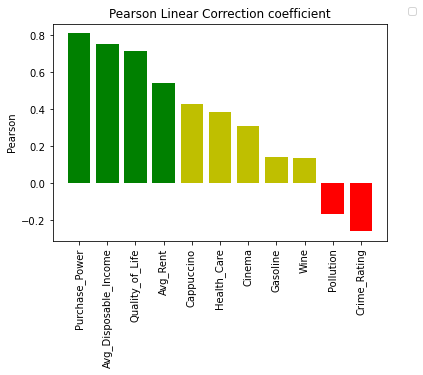

In [62]:
quantidade = [1,2,3,4,5,6,7,8,9,10,11]
colors = ['g','g','g','g','y','y','y','y','y','r','r']
numbers = [0.81049364263681856,0.751426,0.713844,0.542362,0.429955,0.384803,0.310625,0.142297,0.136347,-0.167520,-0.258001]

LABELS = ["Purchase_Power","Avg_Disposable_Income","Quality_of_Life","Avg_Rent","Cappuccino","Health_Care","Cinema","Gasoline","Wine", "Pollution","Crime_Rating"]

plt.bar(quantidade, numbers,color=colors)
plt.xticks(quantidade, LABELS,rotation='vertical')#rotation='vertical'
plt.ticklabel_format
plt.ylabel('Pearson')
plt.title('Pearson Linear Correction coefficient')
#label='Maior correlação negativa')

plt.plot(color="r",label='Higher negative correlation')
    
plt.legend(bbox_to_anchor=(1.1, 1.1))

plt.show()

得出结论:购买力指标、人均可支配收入、生活质量、租房花销与宜居指数呈正相关，相关性较强；
    卡布奇诺、医疗保健、电影院、出行花销和酒与宜居指数呈正相关，相关性较弱；
    污染指数、犯罪指数与宜居指数呈负相关。

特征和movehub散点图

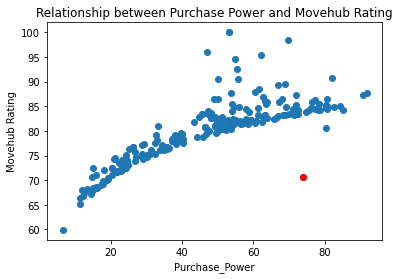

In [63]:
plt.scatter(data.Purchase_Power,data.Movehub_Rating)
plt.scatter(data.Purchase_Power[79],data.Movehub_Rating[79],color='r')
plt.xlabel('Purchase_Power')
plt.ylabel('Movehub Rating')
plt.title('Relationship between Purchase Power and Movehub Rating') #购买力与movehub rating
plt.show()

线性回归模型，根据城市画像指标，预测城市的宜居情况。

In [65]:
X = data.drop(['Movehub_Rating','Country','City'], axis = 1) 
Y = data['Movehub_Rating']
test_size=0.30
seed=42

使用sklearn库

In [66]:
from sklearn.preprocessing import StandardScaler

In [67]:
scaler = StandardScaler()
X=StandardScaler().fit_transform(X)
scaler

StandardScaler()

划分训练集与测试集

In [68]:
from sklearn.model_selection import train_test_split

In [70]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=test_size,
                                                    random_state=seed)
#30%测试集，70%训练集

线性回归

In [83]:
reg_log = linear_model.LinearRegression()
reg_log.fit (X_train,Y_train)

Y_pred = reg_log.predict(X_test)

In [73]:
from sklearn.metrics import explained_variance_score
#解释回归系数
explained_variance_score=explained_variance_score(Y_test, Y_pred)  

In [74]:
from sklearn.metrics import mean_squared_error
#均方差
mean_squared_error=mean_squared_error(Y_test, Y_pred)

In [75]:
from sklearn.metrics import mean_absolute_error
#平均绝对误差 
erro_medio_absoluto=mean_absolute_error(Y_test, Y_pred)

In [86]:
print ("Determination coefficient r²: {:.3f}".format(reg_log.score(X_train,Y_train)))
print ("Determination coefficient r² of the testing set: {:.3f} ".format(reg_log.score(X_test,Y_test)))
print("mean_squared_error: {:.2f} ".format(mean_squared_error))
print("mean_absolute_error: {:.2f} ".format(erro_medio_absoluto))
print("Explained_variance_score: {:.3f} ".format(explained_variance_score))
print ('Linear Coefficient {:.2f}'.format(reg_log.intercept_))
print ('Angular Coefficient{:}'.format(reg_log.coef_))

Determination coefficient r²: 0.774
Determination coefficient r² of the testing set: 0.696 
mean_squared_error: 13.74 
mean_absolute_error: 2.40 
Explained_variance_score: 0.698 
Linear Coefficient 79.79
Angular Coefficient[-0.11650649  0.29693287  0.4074948   1.46337193  1.9769417  -1.97770923
  5.50288655  0.42745248 -0.05672387  0.72094491  0.54551248]


经验证，使用该模型的线性回归系数，测试集和训练集均较高，误差较小

In [88]:
pd.DataFrame(list(zip(Y_test[5:10],Y_pred[5:10]))
             ,columns=['True Values','Estimated Values'])

,True Values,Estimated Values
0,73.19,73.852177
1,66.42,68.253864
2,81.34,81.107558
3,80.17,79.421028
4,84.97,86.928765


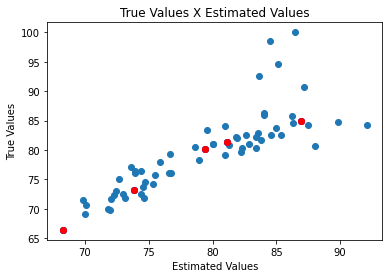

In [90]:
plt.scatter(Y_pred,Y_test)
plt.scatter(Y_pred[5:10],Y_test[5:10],color='b')
plt.scatter(Y_pred[5:10],Y_test[5:10],color='r')
plt.xlabel('Estimated Values')
plt.ylabel('True Values')
plt.title('True Values X Estimated Values')

plt.show()

结论：该线性回归预测模型效果较好，准确率达79.79%